In [12]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/iterativestratification/iterative-stratification-master/setup.py
/kaggle/input/iterativestratification/iterative-stratification-master/.travis.yml
/kaggle/input/iterativestratification/iterative-stratification-master/setup.cfg
/kaggle/input/iterativestratification/iterative-stratification-master/.gitignore
/kaggle/input/iterativestratification/iterative-stratification-master/LICENSE
/kaggle/input/iterativestratification/iterative-stratification-master/README.md
/kaggle/input/iterativestratification/iterative-stratification-master/iterstrat/__init__.py
/kaggle/input/iterativestratification/iterative-stratification-master/iterstrat/ml_stratifiers.py
/kaggle/input/iterativestratification/iterative-stratification-master/tests/__init__.py
/kaggle/input/iterativestratification/iterative-stratification-master/tests/test_ml_stratifiers.py
/kaggle/input/lish-moa/train_targets_scored.csv
/kaggle/input/lish-moa/train_drug.csv
/kaggle/input/lish-moa/train_targets_nonscored.csv
/kaggl

In [15]:
import warnings
warnings.filterwarnings("ignore")

# Adding iterative-stratification 
# Select add data from the right menu and search for iterative-stratification, then add it to your kernel.
import sys
sys.path.append('../input/iterativestratification/iterative-stratification-master')
from iterstrat.ml_stratifiers import MultilabelStratifiedKFold


from time import time
import datetime
import gc

import numpy as np
import pandas as pd 

# ML tools 
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping
import tensorflow as tf 
from tensorflow.keras import layers
import tensorflow.keras.backend as K
from sklearn.metrics import log_loss
from tensorflow_addons.layers import WeightNormalization
# Setting random seeds
np.random.seed(42)
tf.random.set_seed(42)

# Visualization tools
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_style('white')
sns.set(font_scale=1.2)

In [16]:
df_train = pd.read_csv('/kaggle/input/lish-moa/train_features.csv')
display(df_train.head(3))
print('train data size', df_train.shape)

df_target_ns = pd.read_csv('/kaggle/input/lish-moa/train_targets_nonscored.csv')
display(df_target_ns.head(3))
print('train target nonscored size', df_target_ns.shape)


df_target_s = pd.read_csv('/kaggle/input/lish-moa/train_targets_scored.csv')
display(df_target_s.head(3))
print('train target scored size', df_target_s.shape)


df_test = pd.read_csv('/kaggle/input/lish-moa/test_features.csv')
display(df_test.head(3))
print('test data size', df_test.shape)

df_sample = pd.read_csv('/kaggle/input/lish-moa/sample_submission.csv')
display(df_sample.head(3))
print('sample submission size', df_sample.shape)

sig_id cp_type  cp_time cp_dose     g-0     g-1     g-2     g-3  \
0  id_000644bb2  trt_cp       24      D1  1.0620  0.5577 -0.2479 -0.6208   
1  id_000779bfc  trt_cp       72      D1  0.0743  0.4087  0.2991  0.0604   
2  id_000a6266a  trt_cp       48      D1  0.6280  0.5817  1.5540 -0.0764   

      g-4     g-5  ...    c-90    c-91    c-92    c-93    c-94    c-95  \
0 -0.1944 -1.0120  ...  0.2862  0.2584  0.8076  0.5523 -0.1912  0.6584   
1  1.0190  0.5207  ... -0.4265  0.7543  0.4708  0.0230  0.2957  0.4899   
2 -0.0323  1.2390  ... -0.7250 -0.6297  0.6103  0.0223 -1.3240 -0.3174   

     c-96    c-97    c-98    c-99  
0 -0.3981  0.2139  0.3801  0.4176  
1  0.1522  0.1241  0.6077  0.7371  
2 -0.6417 -0.2187 -1.4080  0.6931  

[3 rows x 876 columns]

train data size (23814, 876)


sig_id  abc_transporter_expression_enhancer  abl_inhibitor  \
0  id_000644bb2                                    0              0   
1  id_000779bfc                                    0              0   
2  id_000a6266a                                    0              0   

   ace_inhibitor  acetylcholine_release_enhancer  \
0              0                               0   
1              0                               0   
2              0                               0   

   adenosine_deaminase_inhibitor  adenosine_kinase_inhibitor  \
0                              0                           0   
1                              0                           0   
2                              0                           0   

   adenylyl_cyclase_inhibitor  age_inhibitor  alcohol_dehydrogenase_inhibitor  \
0                           0              0                                0   
1                           0              0                                0   
2                           0              0                                0   

   ...  ve-cadherin_antagonist  vesicular_monoamine_transporter_inhibitor  \
0  ...                       0                                          0   
1  ...                       0                                          0   
2  ...                       0                                          0   

   vitamin_k_antagonist  voltage-gated_calcium_channel_ligand  \
0                     0                                     0   
1                     0                                     0   
2                     0                                     0   

   voltage-gated_potassium_channel_activator  \
0                                          0   
1                                          0   
2                                          0   

   voltage-gated_sodium_channel_blocker  wdr5_mll_interaction_inhibitor  \
0                                     0                               0   
1                                     0                               0   
2                                     0                               0   

   wnt_agonist  xanthine_oxidase_inhibitor  xiap_inhibitor  
0            0                           0               0  
1            0                           0               0  
2            0                           0               0  

[3 rows x 403 columns]

train target nonscored size (23814, 403)


sig_id  5-alpha_reductase_inhibitor  11-beta-hsd1_inhibitor  \
0  id_000644bb2                            0                       0   
1  id_000779bfc                            0                       0   
2  id_000a6266a                            0                       0   

   acat_inhibitor  acetylcholine_receptor_agonist  \
0               0                               0   
1               0                               0   
2               0                               0   

   acetylcholine_receptor_antagonist  acetylcholinesterase_inhibitor  \
0                                  0                               0   
1                                  0                               0   
2                                  0                               0   

   adenosine_receptor_agonist  adenosine_receptor_antagonist  \
0                           0                              0   
1                           0                              0   
2                           0                              0   

   adenylyl_cyclase_activator  ...  tropomyosin_receptor_kinase_inhibitor  \
0                           0  ...                                      0   
1                           0  ...                                      0   
2                           0  ...                                      0   

   trpv_agonist  trpv_antagonist  tubulin_inhibitor  \
0             0                0                  0   
1             0                0                  0   
2             0                0                  0   

   tyrosine_kinase_inhibitor  ubiquitin_specific_protease_inhibitor  \
0                          0                                      0   
1                          0                                      0   
2                          0                                      0   

   vegfr_inhibitor  vitamin_b  vitamin_d_receptor_agonist  wnt_inhibitor  
0                0          0                           0              0  
1                0          0                           0              0  
2                0          0                           0              0  

[3 rows x 207 columns]

train target scored size (23814, 207)


sig_id      cp_type  cp_time cp_dose     g-0     g-1     g-2     g-3  \
0  id_0004d9e33       trt_cp       24      D1 -0.5458  0.1306 -0.5135  0.4408   
1  id_001897cda       trt_cp       72      D1 -0.1829  0.2320  1.2080 -0.4522   
2  id_002429b5b  ctl_vehicle       24      D1  0.1852 -0.1404 -0.3911  0.1310   

      g-4     g-5  ...    c-90    c-91   c-92    c-93    c-94    c-95    c-96  \
0  1.5500 -0.1644  ...  0.0981  0.7978 -0.143 -0.2067 -0.2303 -0.1193  0.0210   
1 -0.3652 -0.3319  ... -0.1190 -0.1852 -1.031 -1.3670 -0.3690 -0.5382  0.0359   
2 -1.4380  0.2455  ... -0.2261  0.3370 -1.384  0.8604 -1.9530 -1.0140  0.8662   

     c-97    c-98    c-99  
0 -0.0502  0.1510 -0.7750  
1 -0.4764 -1.3810 -0.7300  
2  1.0160  0.4924 -0.1942  

[3 rows x 876 columns]

test data size (3982, 876)


sig_id  5-alpha_reductase_inhibitor  11-beta-hsd1_inhibitor  \
0  id_0004d9e33                          0.5                     0.5   
1  id_001897cda                          0.5                     0.5   
2  id_002429b5b                          0.5                     0.5   

   acat_inhibitor  acetylcholine_receptor_agonist  \
0             0.5                             0.5   
1             0.5                             0.5   
2             0.5                             0.5   

   acetylcholine_receptor_antagonist  acetylcholinesterase_inhibitor  \
0                                0.5                             0.5   
1                                0.5                             0.5   
2                                0.5                             0.5   

   adenosine_receptor_agonist  adenosine_receptor_antagonist  \
0                         0.5                            0.5   
1                         0.5                            0.5   
2                         0.5                            0.5   

   adenylyl_cyclase_activator  ...  tropomyosin_receptor_kinase_inhibitor  \
0                         0.5  ...                                    0.5   
1                         0.5  ...                                    0.5   
2                         0.5  ...                                    0.5   

   trpv_agonist  trpv_antagonist  tubulin_inhibitor  \
0           0.5              0.5                0.5   
1           0.5              0.5                0.5   
2           0.5              0.5                0.5   

   tyrosine_kinase_inhibitor  ubiquitin_specific_protease_inhibitor  \
0                        0.5                                    0.5   
1                        0.5                                    0.5   
2                        0.5                                    0.5   

   vegfr_inhibitor  vitamin_b  vitamin_d_receptor_agonist  wnt_inhibitor  
0              0.5        0.5                         0.5            0.5  
1              0.5        0.5                         0.5            0.5  
2              0.5        0.5                         0.5            0.5  

[3 rows x 207 columns]

sample submission size (3982, 207)


In [17]:
print(df_train.isnull().sum().any()) # True if there are missing values
print(df_train.info())

False
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23814 entries, 0 to 23813
Columns: 876 entries, sig_id to c-99
dtypes: float64(872), int64(1), object(3)
memory usage: 159.2+ MB
None


In [18]:
display(df_train.select_dtypes('int64').head(3))
display(df_train.select_dtypes('object').head(3))

cp_time
0       24
1       72
2       48

sig_id cp_type cp_dose
0  id_000644bb2  trt_cp      D1
1  id_000779bfc  trt_cp      D1
2  id_000a6266a  trt_cp      D1

In [19]:
g_features = [cols for cols in df_train.columns if cols.startswith('g-')]

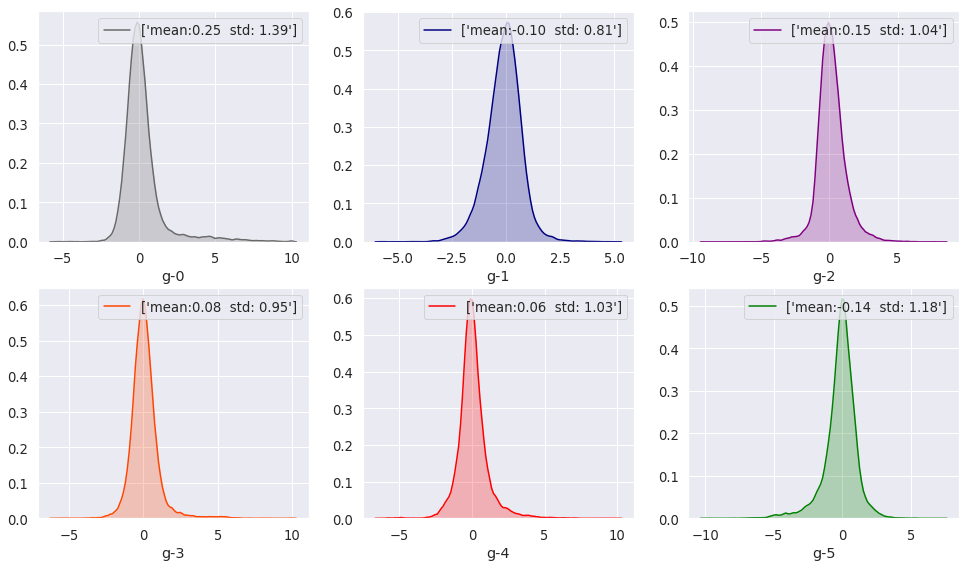

In [20]:
color = ['dimgray','navy','purple','orangered', 'red', 'green' ,'mediumorchid', 'khaki', 'salmon', 'blue','cornflowerblue','mediumseagreen']
 
color_ind=0
n_row = 6
n_col = 3
n_sub = 1 
plt.rcParams["legend.loc"] = 'upper right'
fig = plt.figure(figsize=(8,14))
plt.subplots_adjust(left=-0.3, right=1.3,bottom=-0.3,top=1.3)
for i in (np.arange(0,6,1)):
    plt.subplot(n_row, n_col, n_sub)
    sns.kdeplot(df_train.loc[:,g_features[i]],color=color[color_ind],shade=True,
                 label=['mean:'+str('{:.2f}'.format(df_train.loc[:,g_features[i]].mean()))
                        +'  ''std: '+str('{:.2f}'.format(df_train.loc[:,g_features[i]].std()))])
    
    plt.xlabel(g_features[i])
    plt.legend()                    
    n_sub+=1
    color_ind+=1
plt.show()

In [21]:
c_features = [cols for cols in df_train.columns if cols.startswith('c-')]

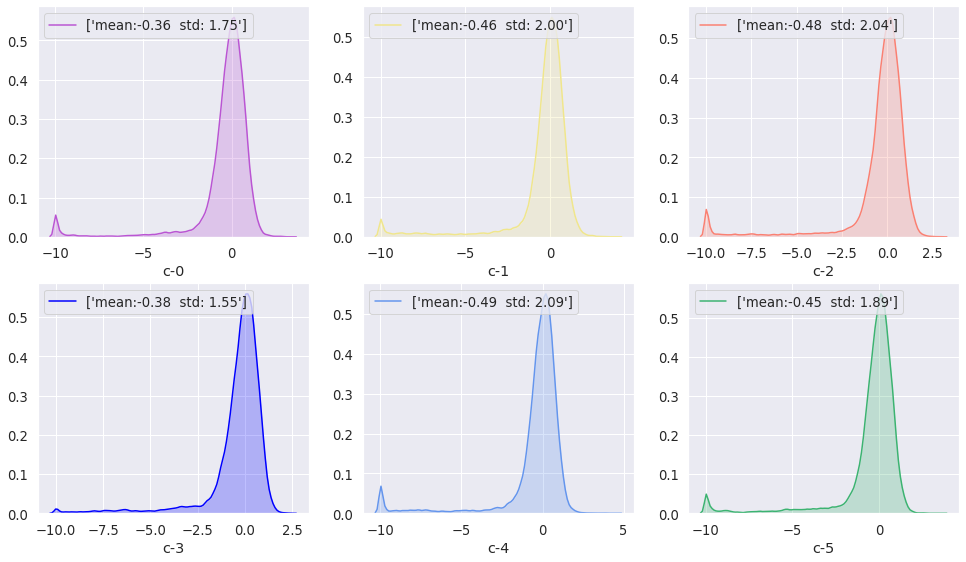

In [22]:
n_row = 6
n_col = 3
n_sub = 1 
fig = plt.figure(figsize=(8,14))
plt.subplots_adjust(left=-0.3, right=1.3,bottom=-0.3,top=1.3)
plt.rcParams["legend.loc"] = 'upper left'
for i in (np.arange(0,6,1)):
    plt.subplot(n_row, n_col, n_sub)
    sns.kdeplot(df_train.loc[:,c_features[i]],color=color[color_ind],shade=True,
                 label=['mean:'+str('{:.2f}'.format(df_train.loc[:,c_features[i]].mean()))
                        +'  ''std: '+str('{:.2f}'.format(df_train.loc[:,c_features[i]].std()))])
    
    plt.xlabel(c_features[i])
    plt.legend()                    
    n_sub+=1
    color_ind+=1
plt.show()

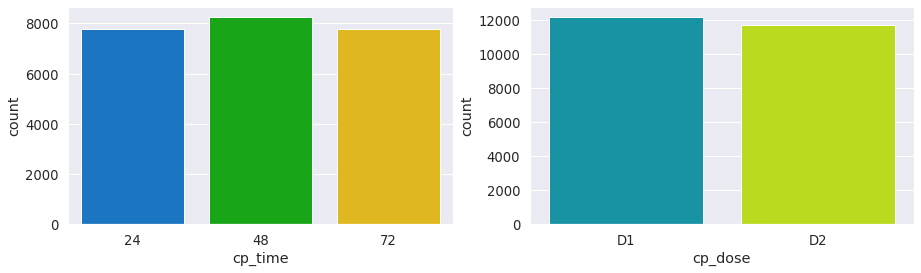

In [23]:
fig = plt.figure(figsize=(10,4))
plt.subplots_adjust(right=1.3)
plt.subplot(1, 2, 1)
sns.countplot(df_train['cp_time'],palette='nipy_spectral')
plt.subplot(1, 2, 2)
sns.countplot(df_train['cp_dose'],palette='nipy_spectral')
plt.show()

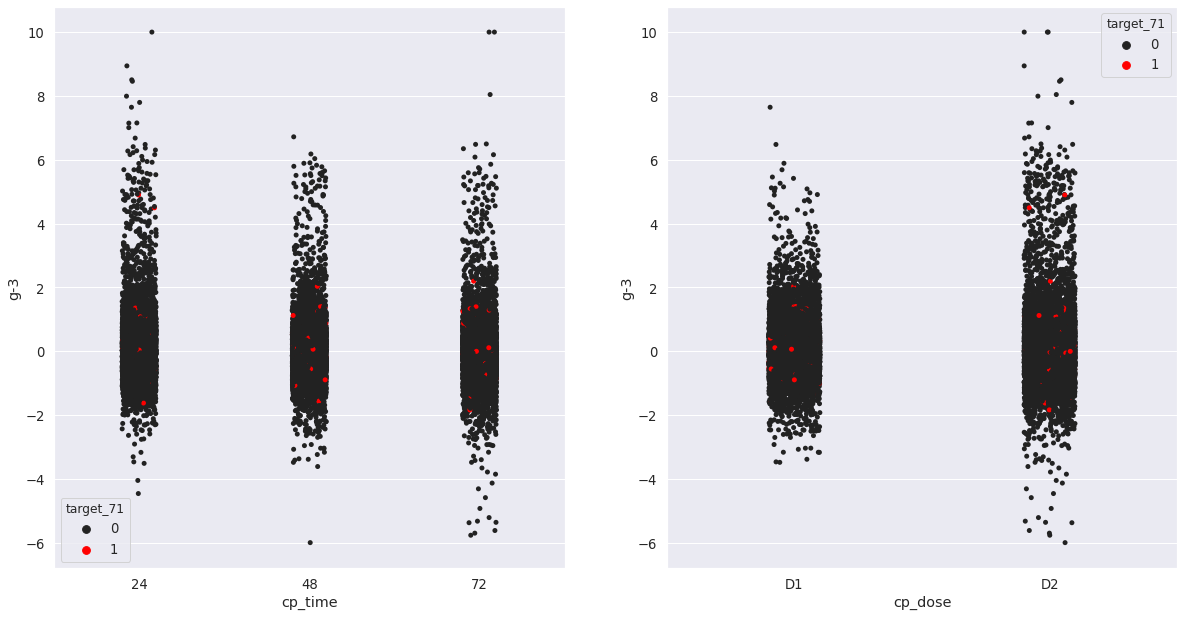

In [24]:
train_copy= df_train.copy()
train_copy['target_71'] = df_target_s.iloc[:,72] # sig_id is included
fig = plt.figure(figsize=(16,8))
plt.subplots_adjust(right=1.1,top=1.1)
ax1 = fig.add_subplot(121)
sns.stripplot(data= train_copy , x='cp_time', y= 'g-3',color='red', hue='target_71',ax=ax1)
ax2 = fig.add_subplot(122)
sns.stripplot(data= train_copy , x='cp_dose', y= 'g-3',color='red', hue='target_71',ax=ax2)
plt.show()

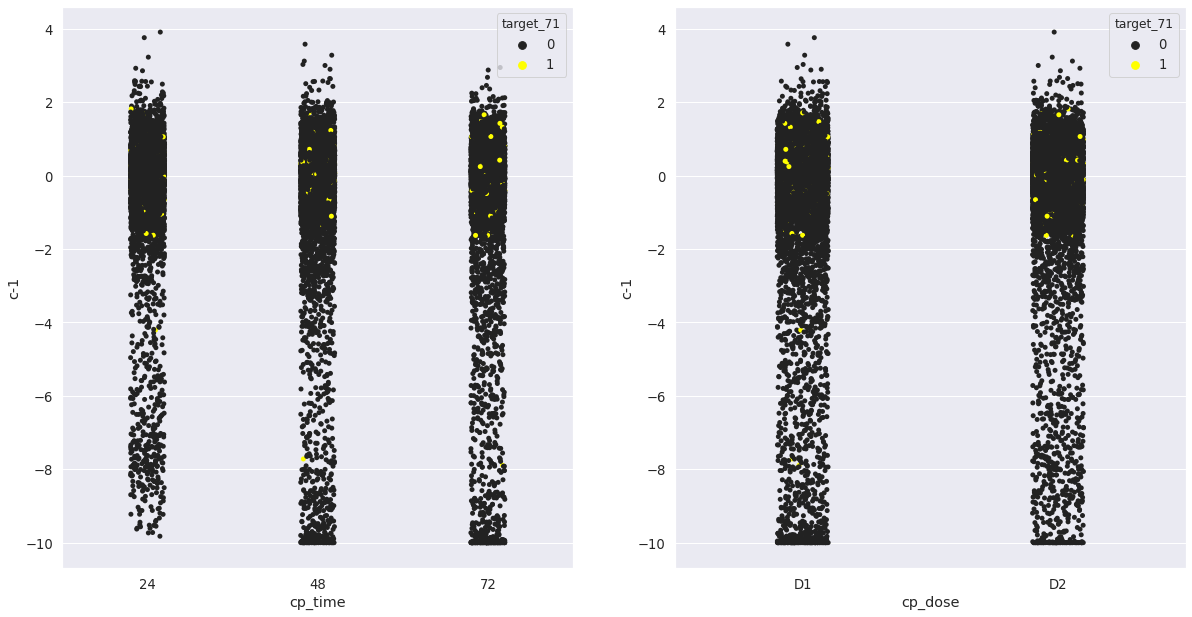

In [25]:
fig = plt.figure(figsize=(16,8))
plt.subplots_adjust(right=1.1,top=1.1)
ax1 = fig.add_subplot(121)
sns.stripplot(data= train_copy, x='cp_time', y= 'c-1',color='yellow', hue='target_71',ax=ax1)
ax2 = fig.add_subplot(122)
sns.stripplot(data= train_copy , x='cp_dose', y= 'c-1',color='yellow', hue='target_71',ax=ax2)
plt.show()

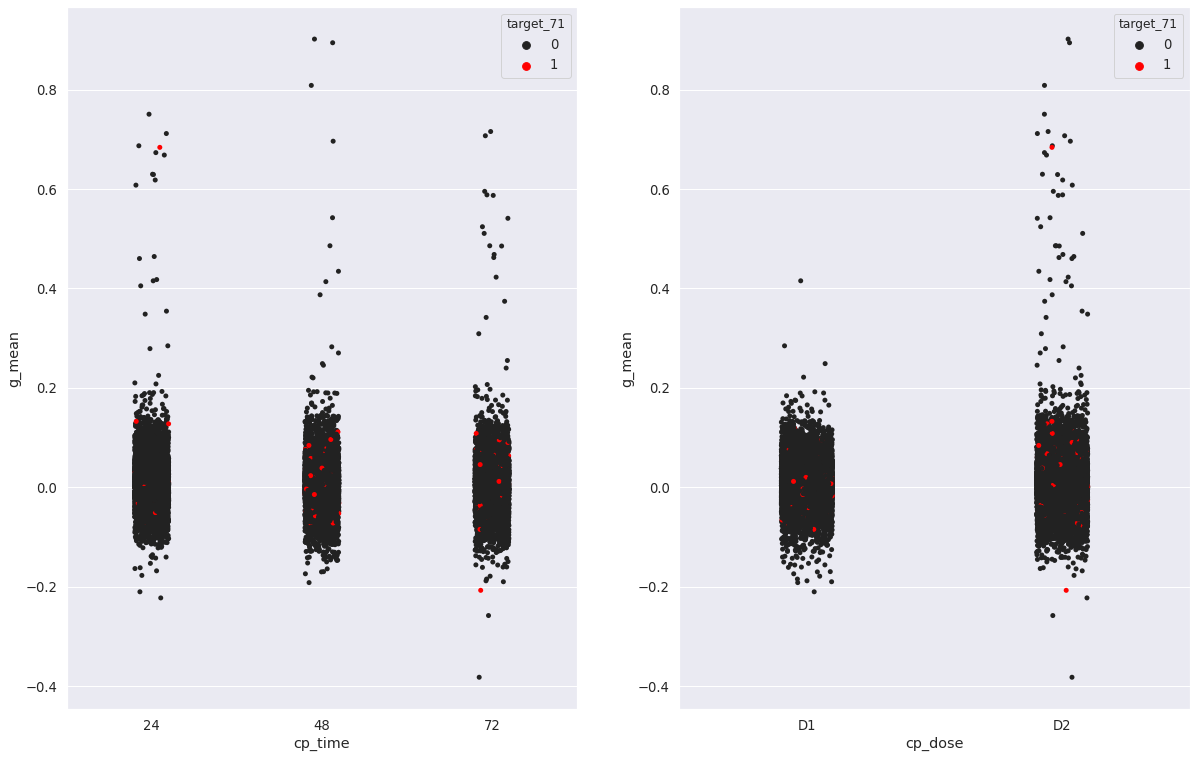

In [26]:
train_copy['g_mean'] = train_copy.loc[:, g_features].mean(axis=1) 
fig = plt.figure(figsize=(16,10))
plt.subplots_adjust(right=1.1,top=1.1)
ax1 = fig.add_subplot(121)
sns.stripplot(data= train_copy , x='cp_time', y= 'g_mean',color='red', hue='target_71',ax=ax1)
ax2 = fig.add_subplot(122)
sns.stripplot(data= train_copy , x='cp_dose', y= 'g_mean', color='red', hue='target_71',ax=ax2)
plt.show()

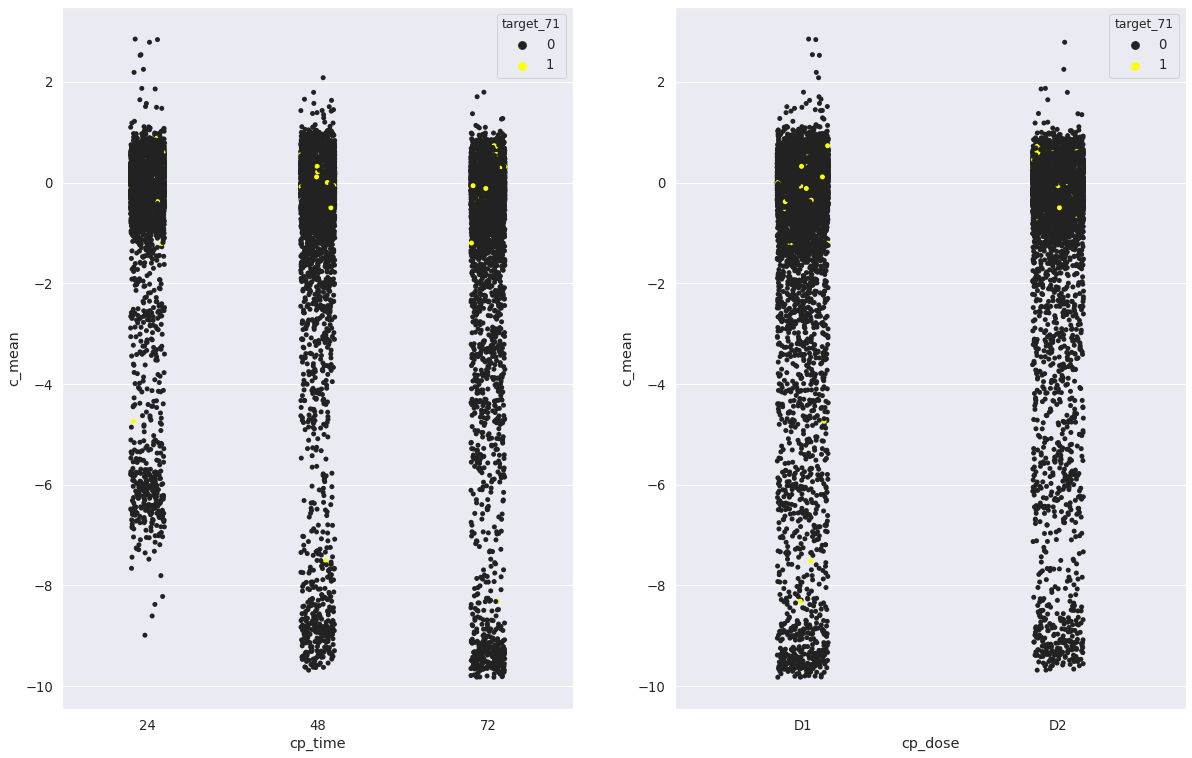

In [27]:
train_copy['c_mean'] = train_copy.loc[:, c_features].mean(axis=1) 
fig = plt.figure(figsize=(16,10))
plt.subplots_adjust(right=1.1,top=1.1)
ax1 = fig.add_subplot(121)
sns.stripplot(data= train_copy, x='cp_time', y= 'c_mean',color='yellow', hue='target_71',ax=ax1)
ax2 = fig.add_subplot(122)
sns.stripplot(data= train_copy , x='cp_dose', y= 'c_mean', color='yellow', hue='target_71',ax=ax2)
plt.show()

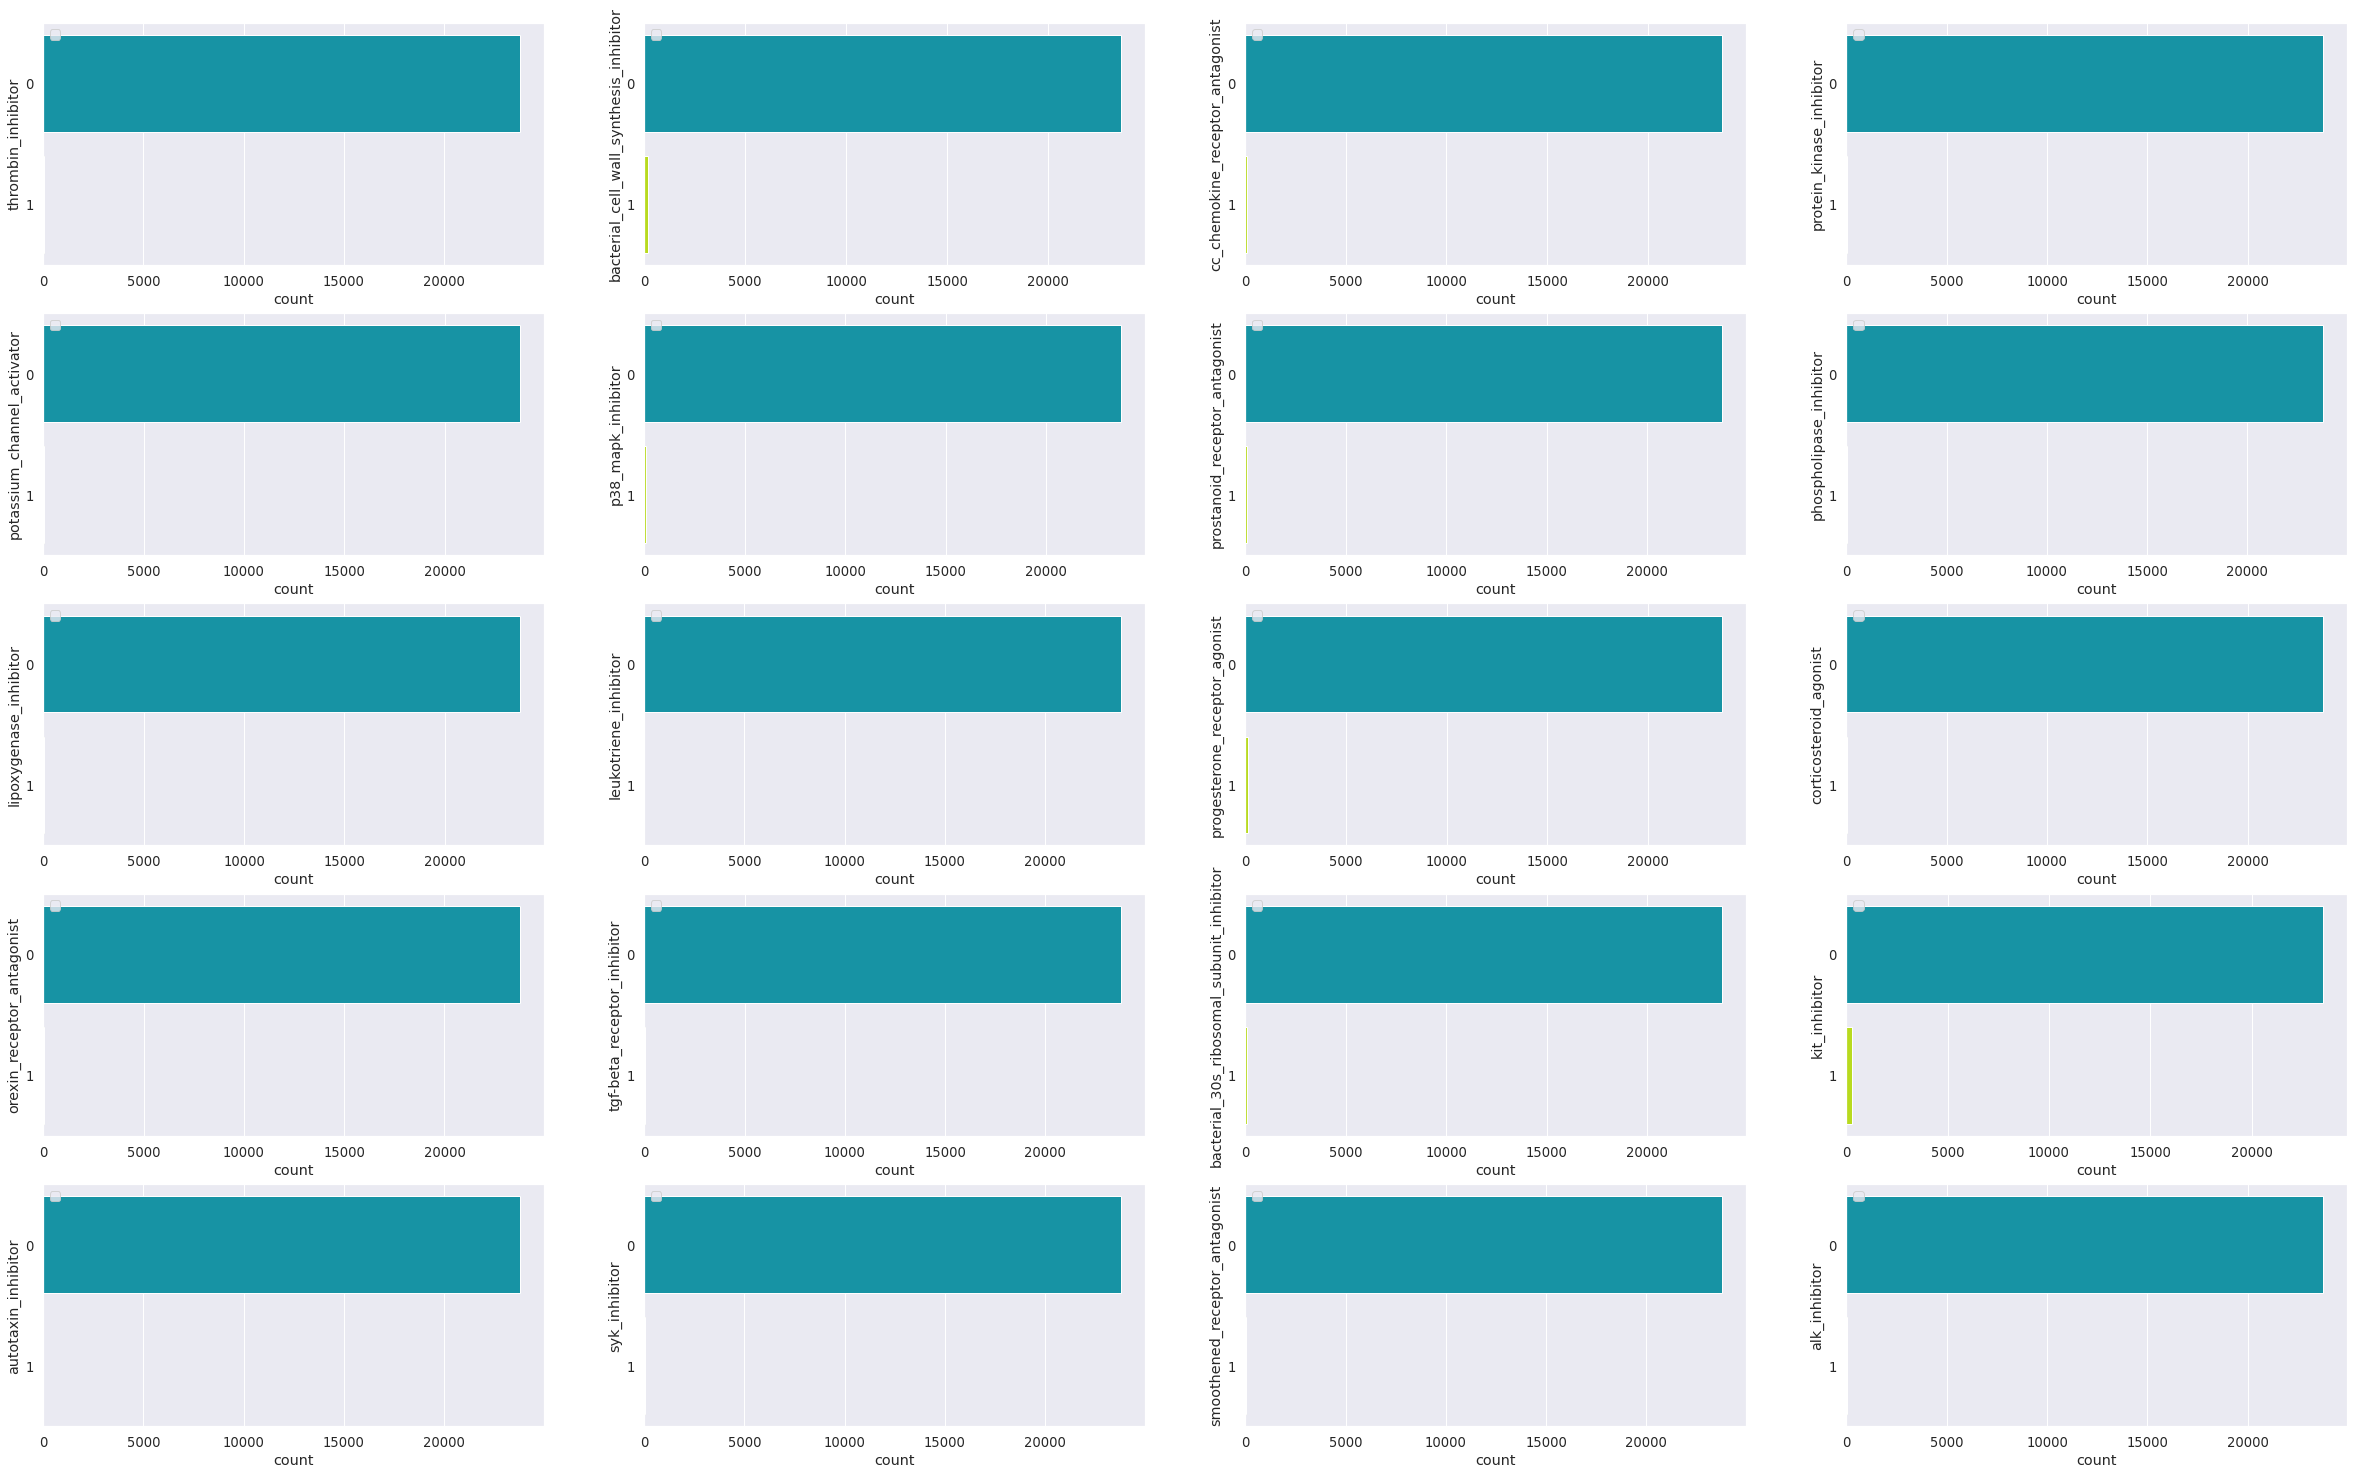

In [28]:
target_s_copy = df_target_s.copy()
target_s_copy.drop('sig_id', axis=1, inplace=True)
n_row = 20
n_col = 4 
n_sub = 1   
fig = plt.figure(figsize=(20,50))
plt.subplots_adjust(left=-0.3, right=1.3,bottom=-0.3,top=1.3)
for i in np.random.choice(np.arange(0,target_s_copy.shape[1],1),n_row):
    plt.subplot(n_row, n_col, n_sub)
    sns.countplot(y=target_s_copy.iloc[:, i],palette='nipy_spectral',orient='h')
    
    plt.legend()                    
    n_sub+=1
plt.show()

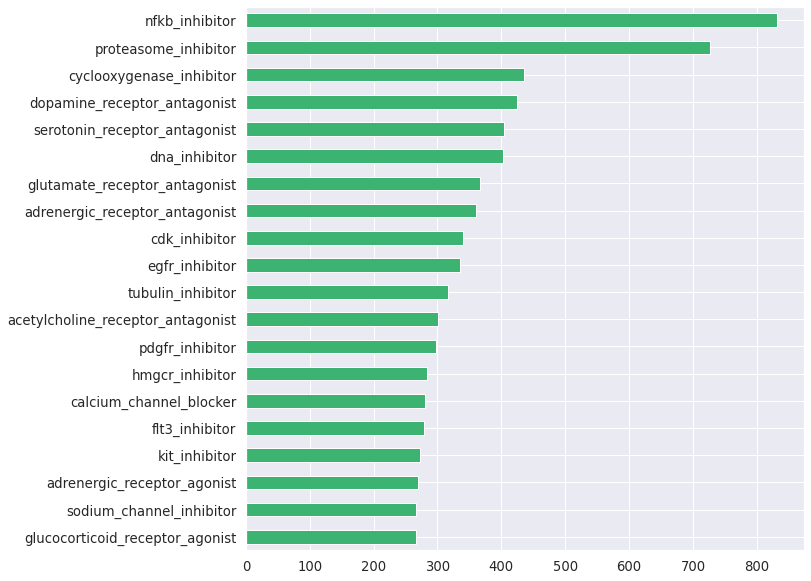

In [31]:
plt.figure(figsize=(10,10))
target_s_copy.sum().sort_values()[-20:].plot(kind='barh',color='mediumseagreen')
plt.show()

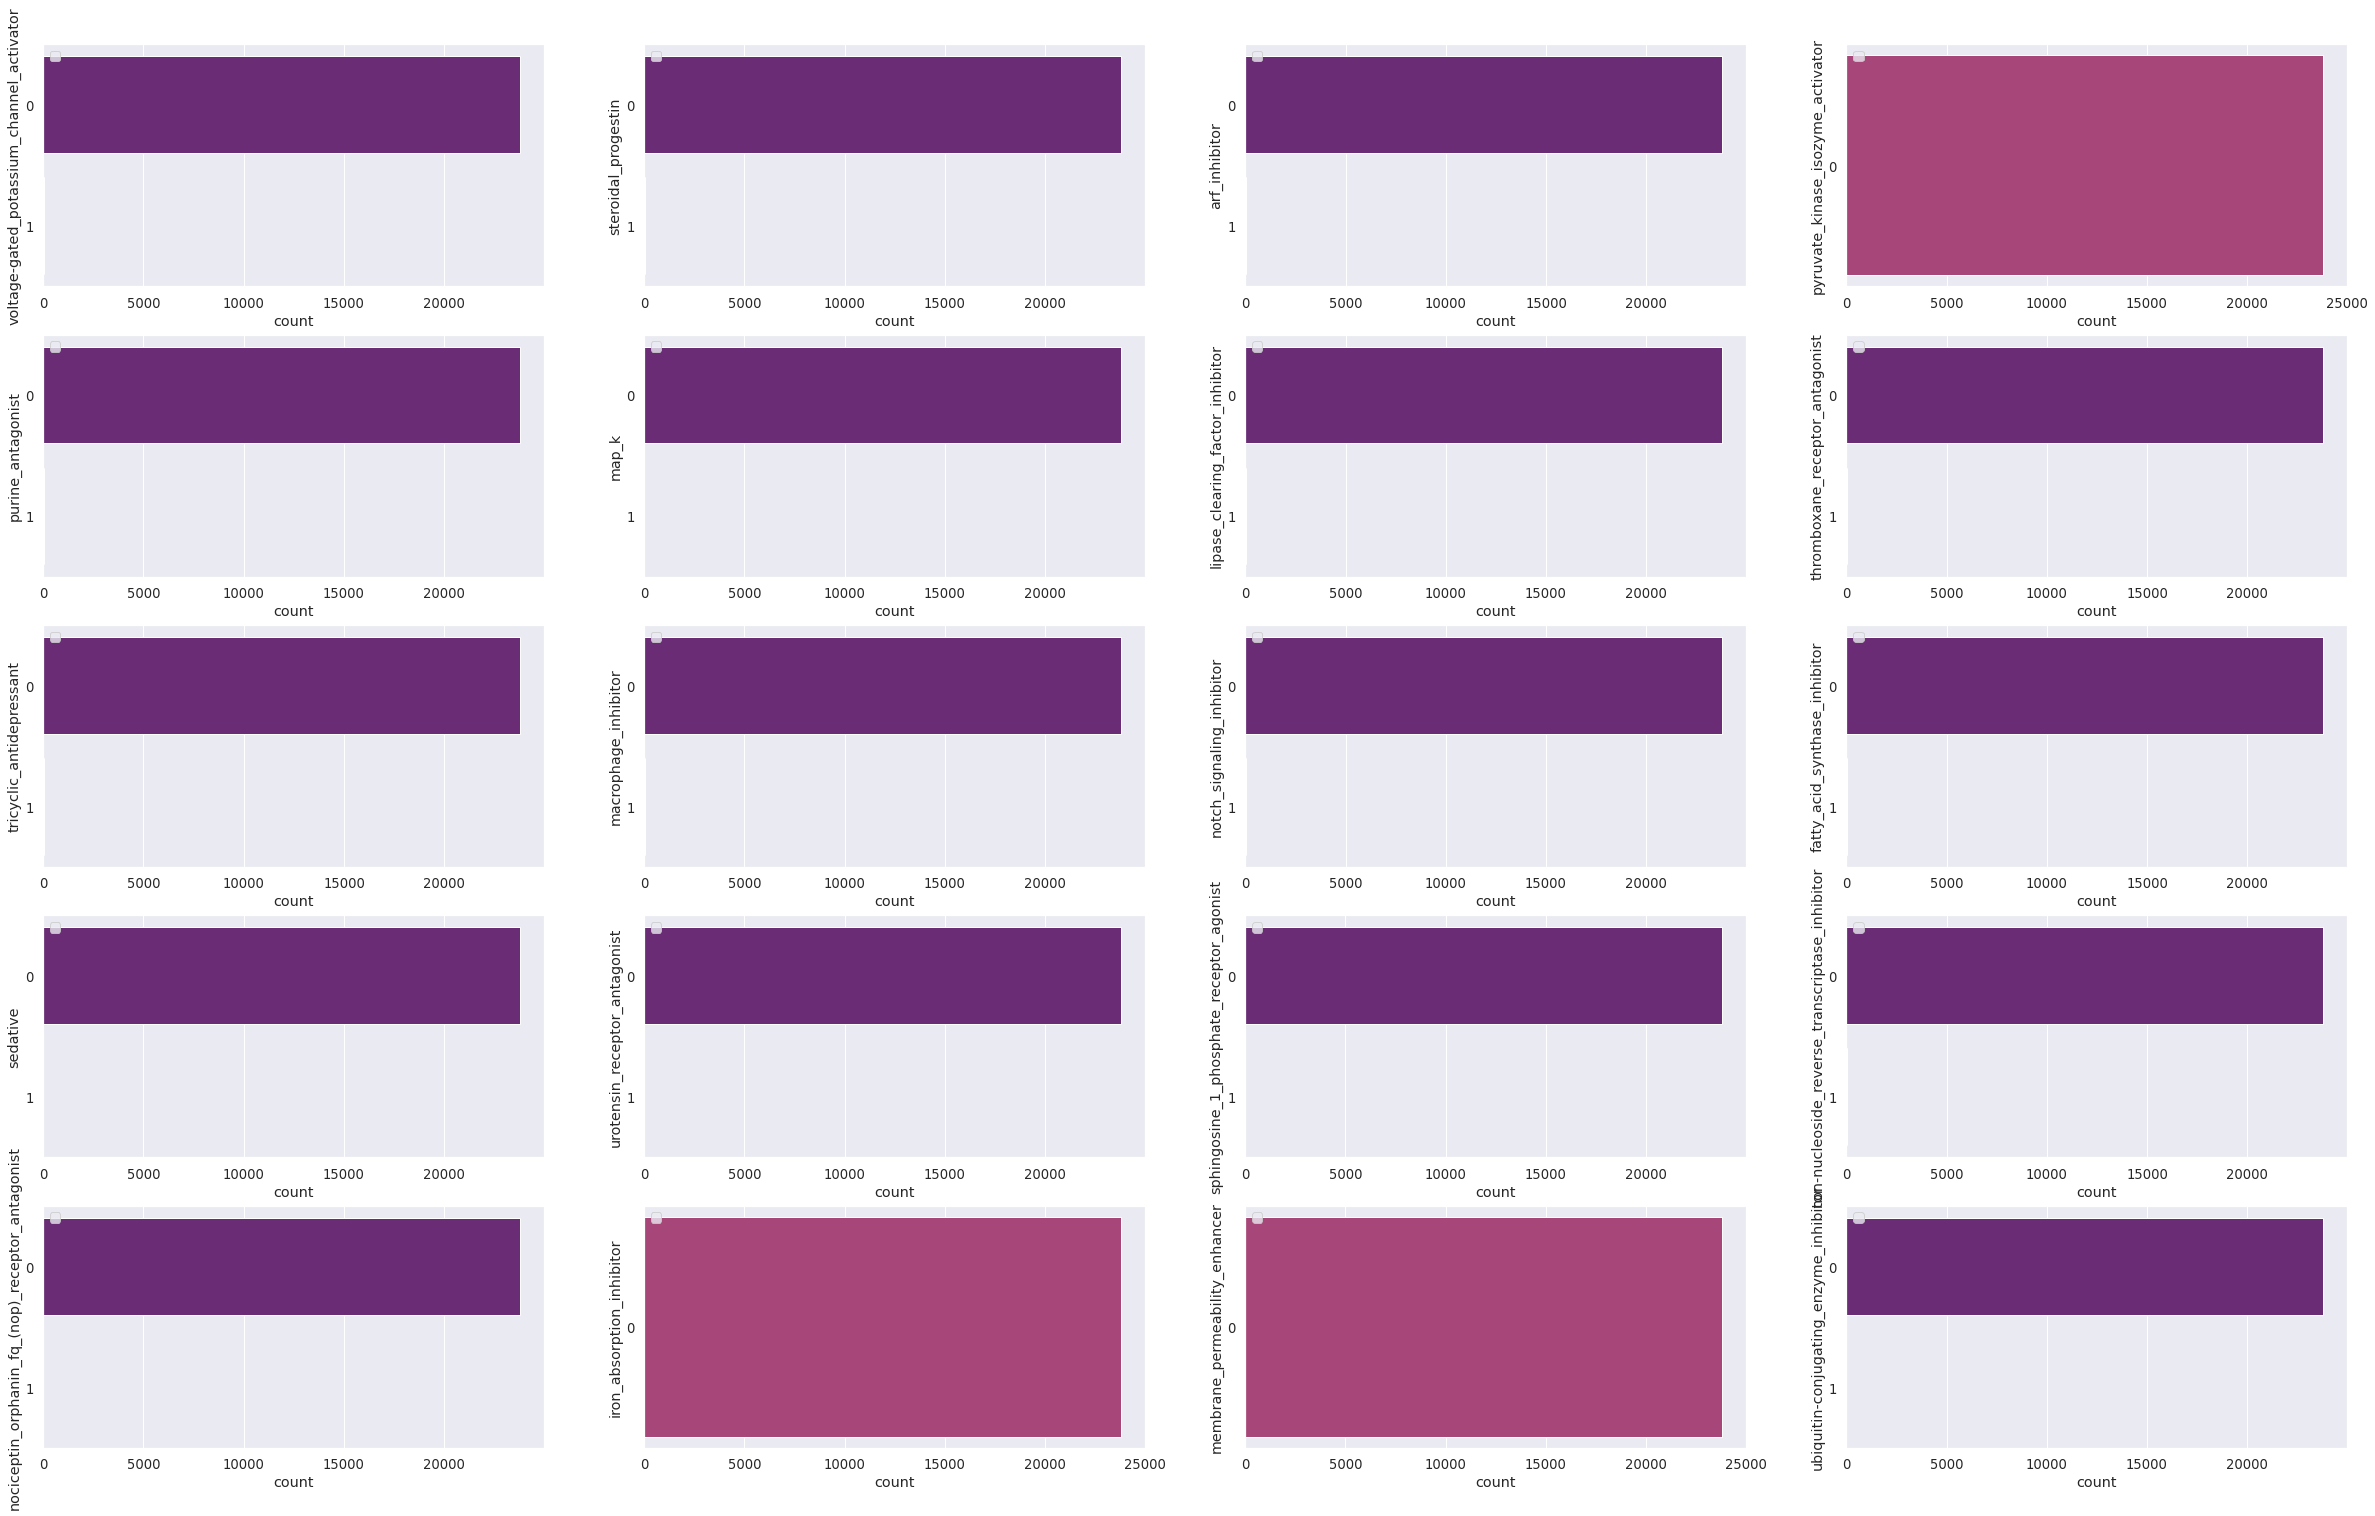

In [32]:
target_ns_copy = df_target_ns.copy()
target_ns_copy.drop('sig_id', axis=1, inplace=True)
n_row = 20
n_col = 4 
n_sub = 1   
fig = plt.figure(figsize=(20,50))
plt.subplots_adjust(left=-0.3, right=1.3,bottom=-0.3,top=1.3)
for i in np.random.choice(np.arange(0,target_ns_copy.shape[1],1),n_row):
    plt.subplot(n_row, n_col, n_sub)
    sns.countplot(y=target_ns_copy.iloc[:, i],palette='magma',orient='h')
    
    plt.legend()                    
    n_sub+=1
plt.show()

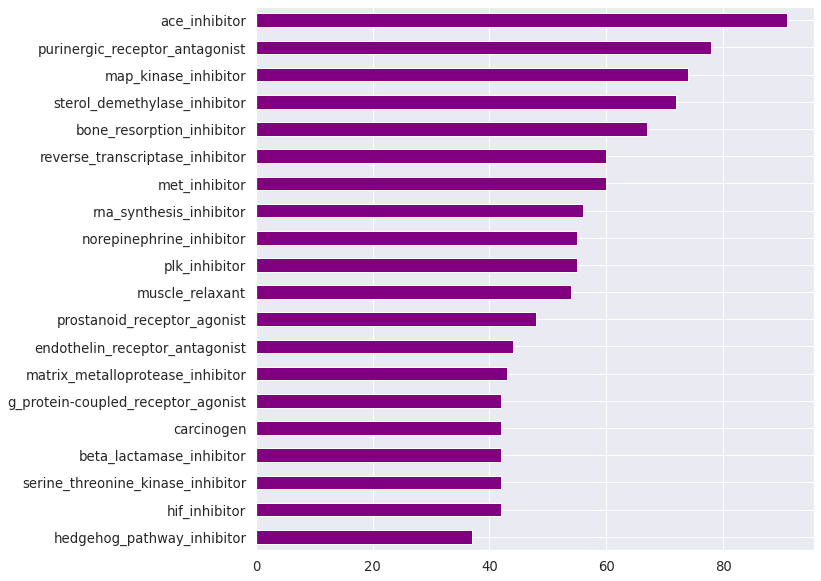

In [33]:
plt.figure(figsize=(10,10))
target_ns_copy.sum().sort_values()[-20:].plot(kind='barh',color='purple')
plt.show()

## Preprocess

In [34]:
ind_tr = df_train[df_train['cp_type']=='ctl_vehicle'].index
ind_te = df_test[df_test['cp_type']=='ctl_vehicle'].index

In [35]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import QuantileTransformer
transformer = QuantileTransformer(n_quantiles=100,random_state=42, output_distribution="normal")

def preprocess(df):
    df['cp_time'] = df['cp_time'].map({24:1, 48:2, 72:3})
    df['cp_dose'] = df['cp_dose'].map({'D1':0, 'D2':1})
    g_features = [cols for cols in df.columns if cols.startswith('g-')]
    c_features = [cols for cols in df.columns if cols.startswith('c-')]
    for col in (g_features + c_features):
        vec_len = len(df[col].values)
        raw_vec = df[col].values.reshape(vec_len, 1)
        transformer.fit(raw_vec)
        df[col] = transformer.transform(raw_vec).reshape(1, vec_len)[0]
    return df

X = preprocess(df_train)
X_test = preprocess(df_test)

display(X.head(5))
print('Train data size', X.shape)
display(X_test.head(3))
print('Test data size', X_test.shape)
y = df_target_s.drop('sig_id', axis=1)
display(y.head(3))
print('target size', y.shape)
y0 =  df_target_ns.drop('sig_id', axis=1)

sig_id cp_type  cp_time  cp_dose       g-0       g-1       g-2  \
0  id_000644bb2  trt_cp        1        0  1.134849  0.907687 -0.416385   
1  id_000779bfc  trt_cp        3        0  0.119282  0.681738  0.272399   
2  id_000a6266a  trt_cp        2        0  0.779973  0.946463  1.425350   
3  id_0015fd391  trt_cp        2        0 -0.734910 -0.274641 -0.438509   
4  id_001626bd3  trt_cp        3        1 -0.452718 -0.477513  0.972316   

        g-3       g-4       g-5  ...      c-90      c-91      c-92      c-93  \
0 -0.966814 -0.254723 -1.017473  ...  0.410974  0.364819  1.291804  0.835350   
1  0.080113  1.205169  0.686517  ... -0.520372  1.127405  0.716111  0.054620   
2 -0.132928 -0.006122  1.492493  ... -0.828896 -0.740965  0.953239  0.053633   
3  0.759097  2.346330 -0.858153  ... -1.419080 -0.756098 -1.652159 -1.250427   
4  0.970731  1.463427 -0.869555  ...  0.018697  0.002153  1.051051  1.682158   

       c-94      c-95      c-96      c-97      c-98      c-99  
0 -0.240101  1.021706 -0.499652  0.317989  0.545662  0.641339  
1  0.412012  0.744215  0.210242  0.179684  0.919161  1.165833  
2 -1.213056 -0.394118 -0.758652 -0.277635 -1.123088  1.089235  
3 -0.947092 -1.231225 -1.325697 -0.977581 -0.485139 -0.915321  
4  0.796356 -0.378324  0.153519  0.428792 -0.475464  1.119408  

[5 rows x 876 columns]

Train data size (23814, 876)


sig_id      cp_type  cp_time  cp_dose       g-0       g-1       g-2  \
0  id_0004d9e33       trt_cp        1        0 -0.755294  0.214796 -0.774511   
1  id_001897cda       trt_cp        3        0 -0.186773  0.374643  1.176402   
2  id_002429b5b  ctl_vehicle        1        0  0.351229 -0.155308 -0.613250   

        g-3       g-4       g-5  ...      c-90      c-91      c-92      c-93  \
0  0.705349  1.564580 -0.194968  ...  0.116890  1.194732 -0.195260 -0.298039   
1 -0.652299 -0.546638 -0.403447  ... -0.183415 -0.269845 -1.059129 -1.317859   
2  0.255053 -1.762152  0.333321  ... -0.328362  0.463214 -1.233935  1.310102   

       c-94      c-95      c-96      c-97      c-98      c-99  
0 -0.301677 -0.128405 -0.036089 -0.094841  0.153376 -0.920303  
1 -0.466468 -0.653500 -0.015480 -0.621168 -1.191952 -0.880456  
2 -1.429491 -1.093671  1.239167  1.577578  0.681627 -0.241098  

[3 rows x 876 columns]

Test data size (3982, 876)


5-alpha_reductase_inhibitor  11-beta-hsd1_inhibitor  acat_inhibitor  \
0                            0                       0               0   
1                            0                       0               0   
2                            0                       0               0   

   acetylcholine_receptor_agonist  acetylcholine_receptor_antagonist  \
0                               0                                  0   
1                               0                                  0   
2                               0                                  0   

   acetylcholinesterase_inhibitor  adenosine_receptor_agonist  \
0                               0                           0   
1                               0                           0   
2                               0                           0   

   adenosine_receptor_antagonist  adenylyl_cyclase_activator  \
0                              0                           0   
1                              0                           0   
2                              0                           0   

   adrenergic_receptor_agonist  ...  tropomyosin_receptor_kinase_inhibitor  \
0                            0  ...                                      0   
1                            0  ...                                      0   
2                            0  ...                                      0   

   trpv_agonist  trpv_antagonist  tubulin_inhibitor  \
0             0                0                  0   
1             0                0                  0   
2             0                0                  0   

   tyrosine_kinase_inhibitor  ubiquitin_specific_protease_inhibitor  \
0                          0                                      0   
1                          0                                      0   
2                          0                                      0   

   vegfr_inhibitor  vitamin_b  vitamin_d_receptor_agonist  wnt_inhibitor  
0                0          0                           0              0  
1                0          0                           0              0  
2                0          0                           0              0  

[3 rows x 206 columns]

target size (23814, 206)


In [36]:
# Please see reference 3 for this part
g_features = [cols for cols in X.columns if cols.startswith('g-')]
n_comp = 0.95

data = pd.concat([pd.DataFrame(X[g_features]), pd.DataFrame(X_test[g_features])])
data2 = (PCA(0.95, random_state=42).fit_transform(data[g_features]))
train2 = data2[:X.shape[0]]
test2 = data2[-X_test.shape[0]:]

train2 = pd.DataFrame(train2, columns=[f'pca_g-{i}' for i in range(data2.shape[1])])
test2 = pd.DataFrame(test2, columns=[f'pca_g-{i}' for i in range(data2.shape[1])])

X = pd.concat((X, train2), axis=1)
X_test = pd.concat((X_test, test2), axis=1)

c_features = [cols for cols in X.columns if cols.startswith('c-')]
n_comp = 0.95

data = pd.concat([pd.DataFrame(X[c_features]), pd.DataFrame(X_test[c_features])])
data2 = (PCA(0.95, random_state=42).fit_transform(data[c_features]))
train2 = data2[:X.shape[0]]
test2 = data2[-X_test.shape[0]:]

train2 = pd.DataFrame(train2, columns=[f'pca_c-{i}' for i in range(data2.shape[1])])
test2 = pd.DataFrame(test2, columns=[f'pca_c-{i}' for i in range(data2.shape[1])])

X = pd.concat((X, train2), axis=1)
X_test = pd.concat((X_test, test2), axis=1)
from sklearn.feature_selection import VarianceThreshold

var_thresh = VarianceThreshold(0.8)  
data = X.append(X_test)
data_transformed = var_thresh.fit_transform(data.iloc[:, 4:])

train_features_transformed = data_transformed[ : X.shape[0]]
test_features_transformed = data_transformed[-X_test.shape[0] : ]


X = pd.DataFrame(X[['sig_id','cp_type', 'cp_time','cp_dose']].values.reshape(-1, 4),\
                              columns=['sig_id','cp_type','cp_time','cp_dose'])

X = pd.concat([X, pd.DataFrame(train_features_transformed)], axis=1)


X_test = pd.DataFrame(X_test[['sig_id','cp_type', 'cp_time','cp_dose']].values.reshape(-1, 4),\
                             columns=['sig_id','cp_type','cp_time','cp_dose'])

X_test = pd.concat([X_test, pd.DataFrame(test_features_transformed)], axis=1)

display(X.head(2))
print(X.shape)
display(X_test.head(2))
print(X_test.shape)

sig_id cp_type cp_time cp_dose         0         1         2  \
0  id_000644bb2  trt_cp       1       0  1.134849  0.907687 -0.416385   
1  id_000779bfc  trt_cp       3       0  0.119282  0.681738  0.272399   

          3         4         5  ...      1029      1030      1031      1032  \
0 -0.966814 -0.254723 -1.017473  ...  0.779615  4.917651  1.538645 -1.560099   
1  0.080113  1.205169  0.686517  ...  0.853780  5.090695 -0.368828  0.013911   

       1033      1034      1035      1036      1037      1038  
0  1.127068  0.908941 -1.080358 -0.253258  0.115213 -0.226061  
1  0.994664 -0.502353  0.673057 -0.272862  0.455034 -1.085957  

[2 rows x 1043 columns]

(23814, 1043)


sig_id cp_type cp_time cp_dose         0         1         2  \
0  id_0004d9e33  trt_cp       1       0 -0.755294  0.214796 -0.774511   
1  id_001897cda  trt_cp       3       0 -0.186773  0.374643  1.176402   

          3         4         5  ...      1029      1030      1031      1032  \
0  0.705349  1.564580 -0.194968  ... -0.878241 -0.804259 -1.899650  0.657893   
1 -0.652299 -0.546638 -0.403447  ... -0.409850 -5.397308 -0.456508  0.290936   

       1033      1034      1035      1036      1037      1038  
0 -0.338125  0.099395 -0.800232  0.523428 -0.393640 -0.745169  
1 -1.095456 -0.612847  1.042001  0.832567  1.149697  0.106494  

[2 rows x 1043 columns]

(3982, 1043)


In [37]:
from sklearn.cluster import KMeans
def fe_cluster(train, test, n_clusters_g = 35, n_clusters_c = 5, SEED = 239):
    
    features_g = list(train.columns[4:776])
    features_c = list(train.columns[776:876])
    def create_cluster(train, test, features, kind = 'g', n_clusters = n_clusters_g):
        train_ = train[features].copy()
        test_ = test[features].copy()
        data = pd.concat([train_, test_], axis = 0)
        kmeans = KMeans(n_clusters = n_clusters, random_state = SEED).fit(data)
        train[f'clusters_{kind}'] = kmeans.labels_[:train.shape[0]]
        test[f'clusters_{kind}'] = kmeans.labels_[train.shape[0]:]
        train = pd.get_dummies(train, columns = [f'clusters_{kind}'])
        test = pd.get_dummies(test, columns = [f'clusters_{kind}'])
        return train, test
    
    train, test = create_cluster(train, test, features_g, kind = 'g', n_clusters = n_clusters_g)
    train, test = create_cluster(train, test, features_c, kind = 'c', n_clusters = n_clusters_c)
    return train, test

X ,X_test=fe_cluster(X,X_test)
display(X.head(2))
print(X.shape)
display(X_test.head(2))
print(X_test.shape)

sig_id cp_type cp_time cp_dose         0         1         2  \
0  id_000644bb2  trt_cp       1       0  1.134849  0.907687 -0.416385   
1  id_000779bfc  trt_cp       3       0  0.119282  0.681738  0.272399   

          3         4         5  ...  clusters_g_30  clusters_g_31  \
0 -0.966814 -0.254723 -1.017473  ...              0              0   
1  0.080113  1.205169  0.686517  ...              0              0   

   clusters_g_32  clusters_g_33  clusters_g_34  clusters_c_0  clusters_c_1  \
0              0              0              0             0             0   
1              0              0              0             1             0   

   clusters_c_2  clusters_c_3  clusters_c_4  
0             0             1             0  
1             0             0             0  

[2 rows x 1083 columns]

(23814, 1083)


sig_id cp_type cp_time cp_dose         0         1         2  \
0  id_0004d9e33  trt_cp       1       0 -0.755294  0.214796 -0.774511   
1  id_001897cda  trt_cp       3       0 -0.186773  0.374643  1.176402   

          3         4         5  ...  clusters_g_30  clusters_g_31  \
0  0.705349  1.564580 -0.194968  ...              0              0   
1 -0.652299 -0.546638 -0.403447  ...              0              0   

   clusters_g_32  clusters_g_33  clusters_g_34  clusters_c_0  clusters_c_1  \
0              0              0              0             0             0   
1              0              0              0             0             0   

   clusters_c_2  clusters_c_3  clusters_c_4  
0             1             0             0  
1             1             0             0  

[2 rows x 1083 columns]

(3982, 1083)


In [38]:
def fe_stats(train, test):
    
    features_g = list(train.columns[4:776])
    features_c = list(train.columns[776:876])
    
    for df in train, test:
        df['g_sum'] = df[features_g].sum(axis = 1)
        df['g_mean'] = df[features_g].mean(axis = 1)
        df['g_std'] = df[features_g].std(axis = 1)
        df['g_kurt'] = df[features_g].kurtosis(axis = 1)
        df['g_skew'] = df[features_g].skew(axis = 1)
        df['c_sum'] = df[features_c].sum(axis = 1)
        df['c_mean'] = df[features_c].mean(axis = 1)
        df['c_std'] = df[features_c].std(axis = 1)
        df['c_kurt'] = df[features_c].kurtosis(axis = 1)
        df['c_skew'] = df[features_c].skew(axis = 1)
        df['gc_sum'] = df[features_g + features_c].sum(axis = 1)
        df['gc_mean'] = df[features_g + features_c].mean(axis = 1)
        df['gc_std'] = df[features_g + features_c].std(axis = 1)
        df['gc_kurt'] = df[features_g + features_c].kurtosis(axis = 1)
        df['gc_skew'] = df[features_g + features_c].skew(axis = 1)
        
    return train, test

X,X_test=fe_stats(X,X_test)
display(X.head(2))
print(X.shape)
display(X_test.head(2))
print(X_test.shape)

sig_id cp_type cp_time cp_dose         0         1         2  \
0  id_000644bb2  trt_cp       1       0  1.134849  0.907687 -0.416385   
1  id_000779bfc  trt_cp       3       0  0.119282  0.681738  0.272399   

          3         4         5  ...      c_sum    c_mean     c_std    c_kurt  \
0 -0.966814 -0.254723 -1.017473  ...  48.445252  0.484453  0.729866 -0.305222   
1  0.080113  1.205169  0.686517  ...  49.649828  0.496498  0.607660  0.106481   

     c_skew     gc_sum   gc_mean    gc_std   gc_kurt   gc_skew  
0  0.068575  40.719854  0.046697  0.862286 -0.255588 -0.009789  
1 -0.159728  50.682229  0.058122  0.830287 -0.204193 -0.037680  

[2 rows x 1098 columns]

(23814, 1098)


sig_id cp_type cp_time cp_dose         0         1         2  \
0  id_0004d9e33  trt_cp       1       0 -0.755294  0.214796 -0.774511   
1  id_001897cda  trt_cp       3       0 -0.186773  0.374643  1.176402   

          3         4         5  ...      c_sum    c_mean     c_std    c_kurt  \
0  0.705349  1.564580 -0.194968  ... -11.302477 -0.113025  0.675216 -0.300185   
1 -0.652299 -0.546638 -0.403447  ... -55.379215 -0.553792  0.626056  0.196417   

     c_skew     gc_sum   gc_mean    gc_std   gc_kurt   gc_skew  
0  0.284487 -48.858313 -0.056030  0.740781  0.017836  0.152192  
1  0.656194 -87.283151 -0.100095  0.925253 -0.678799  0.119278  

[2 rows x 1098 columns]

(3982, 1098)


In [39]:
y0 = y0[X['cp_type'] == 'trt_cp'].reset_index(drop = True)
y = y[X['cp_type'] == 'trt_cp'].reset_index(drop = True)
X = X[X['cp_type'] == 'trt_cp'].reset_index(drop = True)
X.drop(['cp_type','sig_id'], axis=1, inplace=True)
X_test.drop(['cp_type','sig_id'], axis=1, inplace=True)

print('New data shape', X.shape)

New data shape (21948, 1096)


## Training

In [40]:
p_min = 0.001
p_max = 0.999
from tensorflow.keras import regularizers

def logloss(y_true, y_pred):
    y_pred = tf.clip_by_value(y_pred,p_min,p_max)
    return -K.mean(y_true*K.log(y_pred) + (1-y_true)*K.log(1-y_pred))

def create_model(num_cols, hid_layers, activations, dropout_rate, lr, num_cols_y):
    
    inp1 = tf.keras.layers.Input(shape = (num_cols, ))
    x1 = tf.keras.layers.BatchNormalization()(inp1)

    for i, units in enumerate(hid_layers):
        x1 = tf.keras.layers.Dense(units, activation=activations[i])(x1)
        x1 = tf.keras.layers.Dropout(dropout_rate[i])(x1)
        x1 = tf.keras.layers.BatchNormalization()(x1)
    
    x1 = tf.keras.layers.Dense(num_cols_y,activation='sigmoid')(x1)
    model = tf.keras.models.Model(inputs= inp1, outputs= x1)
    
    model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=lr),
                 loss=tf.keras.losses.BinaryCrossentropy(label_smoothing=0.001), metrics=logloss)
    
    return model 
    

In [41]:
hid_layers = [[1152, 1152, 2048],[1408, 1152, 1920],[1280,1152,1920],[896, 768, 2048],
              [1280, 768, 2048], [1152, 2048, 1280], [768,512,2048],[1664,1408,1280],
              [1792, 1024, 2048],[1408,1280,2048]]

dropout_rate = [[0.7,0.7,0.3],[0.7,0.65,0.45],[0.7,0.55,0.3],[0.7,0.7,0.3],
                [0.7,0.7,0.3],[0.7,0.7,0.6],[0.65,0.7,0.3],[0.65,0.7,0.6],
               [0.65, 0.7, 0.6],[0.65, 0.65, 0.3]]

activations = [['selu', 'swish', 'swish'], ['selu','swish','swish'], ['selu','swish','swish'],
              ['selu','swish','elu'],['selu','swish','elu'],['selu','swish','swish'],
               ['selu','swish','selu'],['selu','swish','swish'],['selu','swish','swish'],
               ['selu','swish','elu']]

lr = [0.0012054849811548377,0.0009192456432182012,0.0011414191287409136,0.002144285735125235,
      0.0006784892940023921,0.0011478043498861323, 0.0007956449691617399,
      0.0009414537351021673, 0.0014750672628994098, 0.0016376429795544808]

feats = np.arange(0,X.shape[1],1)
inp_size = int(np.ceil(1* len(feats)))
res = y.copy()
df_sample.loc[:, y.columns] = 0
res.loc[:, y.columns] = 0



In [42]:
# Defining callbacks

def callbacks():
    rlr = ReduceLROnPlateau(monitor = 'val_logloss', factor = 0.2, patience = 3, verbose = 0, 
                                min_delta = 1e-4, min_lr = 1e-6, mode = 'min')
        
    ckp = ModelCheckpoint("model.h5", monitor = 'val_logloss', verbose = 0, 
                              save_best_only = True, mode = 'min')
        
    es = EarlyStopping(monitor = 'val_logloss', min_delta = 1e-5, patience = 10, mode = 'min', 
                           baseline = None, restore_best_weights = True, verbose = 0)
    return rlr, ckp, es

In [43]:
def log_loss_metric(y_true, y_pred):
    metrics = []
    for _target in y.columns:
        metrics.append(log_loss(y_true.loc[:, _target], y_pred.loc[:, _target].astype(float), labels = [0,1]))
    return np.mean(metrics)

## Training and Validation

In [44]:
test_preds = []
res_preds = []
np.random.seed(seed=42)
n_split = 5
n_top = 10
seeds = [34, 9]
n_round = len(seeds)

for seed in seeds:
    split_cols = np.random.choice(feats, inp_size, replace=False)
    res.loc[:, y.columns] = 0
    df_sample.loc[:, y.columns] = 0
    for n, (tr, te) in enumerate(MultilabelStratifiedKFold(n_splits = n_split, random_state = seed, shuffle = True).split(X, y)):
        
        start_time = time()
        x_tr = X.astype('float64').values[tr][:, split_cols]
        x_val = X.astype('float64').values[te][:, split_cols]
        y0_tr, y0_val = y0.astype(float).values[tr], y0.astype(float).values[te]
        y_tr, y_val = y.astype(float).values[tr], y.astype(float).values[te]
        x_tt = X_test.astype('float64').values[:, split_cols]
        
        for num in range(n_top):
            model = create_model(inp_size, hid_layers[num], activations[num], dropout_rate[num], lr[num], y0.shape[1])
            model.fit(x_tr, y0_tr,validation_data=(x_val, y0_val), epochs = 150, batch_size = 128,
                      callbacks = callbacks(), verbose = 0)
            model.load_weights("model.h5")

            model2 = create_model(inp_size, hid_layers[num], activations[num], dropout_rate[num], lr[num], y.shape[1])
            for i in range(len(model2.layers)-1):
                model2.layers[i].set_weights(model.layers[i].get_weights())

            model2.fit(x_tr, y_tr,validation_data=(x_val, y_val),
                            epochs = 150, batch_size = 128,
                            callbacks = callbacks(), verbose = 0)
                       
            model2.load_weights('model.h5')
        
            df_sample.loc[:, y.columns] += model2.predict(x_tt, batch_size = 128)/(n_split*n_top)
        
            res.loc[te, y.columns] += model2.predict(x_val, batch_size = 128)/(n_top)
        
        oof = log_loss_metric(y.loc[te,y.columns], res.loc[te, y.columns])
        print(f'[{str(datetime.timedelta(seconds = time() - start_time))[2:7]}], Seed {seed}, Fold {n}:', oof)

        K.clear_session()
        del model2, model
        x = gc.collect()

    df_sample.loc[ind_te, y.columns] = 0
    
    test_preds.append(df_sample.copy())
    
    res_preds.append(res.copy())

[09:53], Seed 34, Fold 0: 0.016150321363400173
[09:55], Seed 34, Fold 1: 0.016391412617154766
[09:39], Seed 34, Fold 2: 0.016115929381748835
[09:05], Seed 34, Fold 3: 0.016022448027363426
[09:42], Seed 34, Fold 4: 0.016336948663874275
[09:55], Seed 9, Fold 0: 0.01597411403766597
[09:24], Seed 9, Fold 1: 0.01629897318169403
[09:50], Seed 9, Fold 2: 0.016134536925782938
[09:06], Seed 9, Fold 3: 0.016378257828308648
[09:24], Seed 9, Fold 4: 0.0161720126065713


## Blending

In [45]:

aa = [0.5, 0.5]
res2= res.copy()
res2.loc[:, y.columns] = 0
for i in range(n_round):
    res2.loc[:, y.columns] += aa[i] * res_preds[i].loc[:, y.columns]
print(log_loss_metric(y, res2))


0.01615377425385022


In [46]:
df_sample.loc[:, y.columns] = 0
for i in range(n_round):
    df_sample.loc[:, y.columns] += aa[i] * test_preds[i].loc[:, y.columns]
df_sample.loc[ind_te, y.columns] = 0

In [47]:
display(df_sample.head())
df_sample.to_csv('submission.csv', index=False)

sig_id  5-alpha_reductase_inhibitor  11-beta-hsd1_inhibitor  \
0  id_0004d9e33                     0.000663                0.001282   
1  id_001897cda                     0.000709                0.001172   
2  id_002429b5b                     0.000000                0.000000   
3  id_00276f245                     0.000607                0.000687   
4  id_0027f1083                     0.001296                0.001388   

   acat_inhibitor  acetylcholine_receptor_agonist  \
0        0.001643                        0.016632   
1        0.001368                        0.001522   
2        0.000000                        0.000000   
3        0.002484                        0.011099   
4        0.001666                        0.015168   

   acetylcholine_receptor_antagonist  acetylcholinesterase_inhibitor  \
0                           0.023800                        0.005135   
1                           0.002660                        0.002241   
2                           0.000000                        0.000000   
3                           0.010278                        0.003299   
4                           0.026443                        0.005256   

   adenosine_receptor_agonist  adenosine_receptor_antagonist  \
0                    0.002860                       0.005588   
1                    0.003353                       0.013583   
2                    0.000000                       0.000000   
3                    0.002509                       0.005618   
4                    0.005650                       0.003147   

   adenylyl_cyclase_activator  ...  tropomyosin_receptor_kinase_inhibitor  \
0                    0.000344  ...                               0.000975   
1                    0.012424  ...                               0.000620   
2                    0.000000  ...                               0.000000   
3                    0.000331  ...                               0.000820   
4                    0.000387  ...                               0.000758   

   trpv_agonist  trpv_antagonist  tubulin_inhibitor  \
0      0.001292         0.003655           0.001669   
1      0.000969         0.002315           0.000565   
2      0.000000         0.000000           0.000000   
3      0.002585         0.003690           0.031741   
4      0.001121         0.003652           0.002805   

   tyrosine_kinase_inhibitor  ubiquitin_specific_protease_inhibitor  \
0                   0.000711                               0.000816   
1                   0.012423                               0.000777   
2                   0.000000                               0.000000   
3                   0.008413                               0.000640   
4                   0.001121                               0.000753   

   vegfr_inhibitor  vitamin_b  vitamin_d_receptor_agonist  wnt_inhibitor  
0         0.000595   0.001597                    0.003833       0.001539  
1         0.017073   0.001122                    0.002155       0.002271  
2         0.000000   0.000000                    0.000000       0.000000  
3         0.002812   0.001965                    0.002612       0.001756  
4         0.000737   0.001780                    0.001129       0.001383  

[5 rows x 207 columns]